# The Hipster Effect: An IPython Interactive Exploration

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2014/11/11/the-hipster-effect-interactive/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.* It has been adapted to use HoloViews by [Philipp Rudiger](http://philippjfr.com).

This week I started seeing references all over the internet to [this paper](http://arxiv.org/abs/1410.8001): *The Hipster Effect: When Anticonformists All Look The Same*. It essentially describes a simple mathematical model which models conformity and non-conformity among a mutually interacting population, and finds some interesting results: namely, **conformity among a population of self-conscious non-conformists is similar to a phase transition in a time-delayed thermodynamic system**. In other words, with enough hipsters around responding to delayed fashion trends, a plethora of facial hair and fixed gear bikes is a natural result.

Also naturally, upon reading the paper I wanted to try to reproduce the work. The paper solves the problem analytically for a continuous system and shows the precise values of certain phase transitions within the long-term limit of the postulated system. Though such theoretical derivations are useful, I often find it more intuitive to simulate systems like this in a more approximate manner to gain hands-on understanding.

## Mathematically Modeling Hipsters

We'll start by defining the problem, and going through the notation suggested in the paper. We'll consider a group of $N$ people, and define the following quantities:

- $\epsilon_i$ : this value is either $+1$ or $-1$. $+1$ means person $i$ is a hipster, while $-1$ means they're a conformist.
- $s_i(t)$ : this is also either $+1$ or $-1$. This indicates person $i$'s choice of style at time $t$. For example, $+1$ might indicated a bushy beard, while $-1$ indicates clean-shaven.
- $J_{ij}$ : The influence matrix. This is a value greater than zero which indicates how much person $j$ influences person $i$.
- $\tau_{ij}$ : The delay matrix. This is an integer telling us the length of delay for the style of person $j$ to affect the style of person $i$.

The idea of the model is this: on any given day, person $i$ looks at the world around him or her, and sees some previous day's version of everyone else. This information is $s_j(t - \tau_{ij})$.

The amount that person $j$ influences person $i$ is given by the influence matrix, $J_{ij}$, and after putting all the information together, we see that person $i$'s mean impression of the world's style is

$$
m_i(t) = \frac{1}{N} \sum_j J_{ij} \cdot s_j(t - \tau_{ij})
$$

Given the problem setup, we can quickly check whether this impression matches their own current style:

- if $m_i(t) \cdot s_i(t) > 0$, then person $i$ matches those around them
- if $m_i(t) \cdot s_i(t) < 0$, then person $i$ looks different than those around them

A hipster who notices that their style matches that of the world around them will risk giving up all their hipster cred if they don't change quickly; a conformist will have the opposite reaction. Because $\epsilon_i$ = $+1$ for a hipster and $-1$ for a conformist, we can encode this observation in a single value which tells us what which way the person will lean that day:

$$
x_i(t) = -\epsilon_i m_i(t) s_i(t)
$$

Simple! If $x_i(t) > 0$, then person $i$ will more likely switch their style that day, and if $x_i(t) < 0$, person $i$ will more likely maintain the same style as the previous day. So we have a formula for how to update each person's style based on their preferences, their influences, and the world around them.

But the world is a noisy place. Each person might have other things going on that day, so instead of using this value directly, we can turn it in to a probabilistic statement.  Consider the function

$$
\phi(x;\beta) = \frac{1 + \tanh(\beta \cdot x)}{2}
$$

We can plot this function quickly:

In [1]:
import numpy as np
import holoviews as hv
hv.notebook_extension(bokeh=True)

:NdOverlay   [$\beta$]
   :Curve   [$x$]   ($\phi(x;\beta)$)
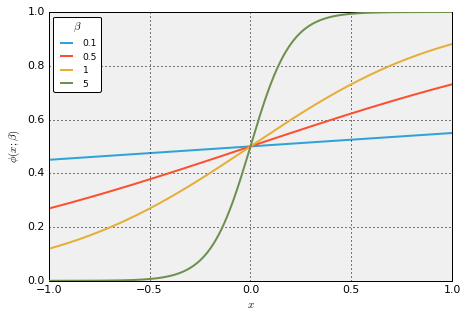

In [5]:
%%output backend='matplotlib'
%%opts NdOverlay [aspect=1.5 figure_size=200 legend_position='top_left']
x = np.linspace(-1, 1, 1000)
curves = hv.NdOverlay(key_dimensions=['$\\beta$'])
for beta in [0.1, 0.5, 1, 5]:
    curves[beta] = hv.Curve(zip(x, 0.5 * (1 + np.tanh(beta * x))), kdims=['$x$'],
                            vdims=['$\\phi(x;\\beta)$'])
curves

This gives us a nice way to move from our preference $x_i$ to a probability of switching styles. Here $\beta$ is inversely related to noise. For large $\beta$, the noise is small and we basically map $x > 0$ to a 100% probability of switching, and $x<0$ to a 0% probability of switching. As $\beta$ gets smaller, the probabilities get less and less distinct.

## The Code

Let's see this model in action. We'll start by defining a class which implements everything we've gone through above:

In [6]:
class HipsterStep(object):
    """Class to implement hipster evolution
    
    Parameters
    ----------
    initial_style : length-N array
        values > 0 indicate one style, while values <= 0 indicate the other.
    is_hipster : length-N array
        True or False, indicating whether each person is a hipster
    influence_matrix : N x N array
        Array of non-negative values. influence_matrix[i, j] indicates
        how much influence person j has on person i
    delay_matrix : N x N array
        Array of positive integers. delay_matrix[i, j] indicates the
        number of days delay between person j's influence on person i.
    """
    def __init__(self, initial_style, is_hipster,
                 influence_matrix, delay_matrix,
                 beta=1, rseed=None):
        self.initial_style = initial_style
        self.is_hipster = is_hipster
        self.influence_matrix = influence_matrix
        self.delay_matrix = delay_matrix
        
        self.rng = np.random.RandomState(rseed)
        self.beta = beta
        
        # make s array consisting of -1 and 1
        self.s = -1 + 2 * (np.atleast_2d(initial_style) > 0)
        N = self.s.shape[1]
        
        # make eps array consisting of -1 and 1
        self.eps = -1 + 2 * (np.asarray(is_hipster) > 0)
        
        # create influence_matrix and delay_matrix
        self.J = np.asarray(influence_matrix, dtype=float)
        self.tau = np.asarray(delay_matrix, dtype=int)
        
        # validate all the inputs
        assert self.s.ndim == 2
        assert self.s.shape[1] == N
        assert self.eps.shape == (N,)
        assert self.J.shape == (N, N)
        assert np.all(self.J >= 0)
        assert np.all(self.tau > 0)

    @staticmethod
    def phi(x, beta):
        return 0.5 * (1 + np.tanh(beta * x))
            
    def step_once(self):
        N = self.s.shape[1]
        
        # iref[i, j] gives the index for the j^th individual's
        # time-delayed influence on the i^th individual
        iref = np.maximum(0, self.s.shape[0] - self.tau)
        
        # sref[i, j] gives the previous state of the j^th individual
        # which affects the current state of the i^th individual
        sref = self.s[iref, np.arange(N)]

        # m[i] is the mean of weighted influences of other individuals
        m = (self.J * sref).sum(1) / self.J.sum(1)
        
        # From m, we use the sigmoid function to compute a transition probability
        transition_prob = self.phi(-self.eps * m * self.s[-1], beta=self.beta)
        
        # Now choose steps stochastically based on this probability
        new_s = np.where(transition_prob > self.rng.rand(N), -1, 1) * self.s[-1]
        
        # Add this to the results, and return
        self.s = np.vstack([self.s, new_s])
        return self.s
    
    def step(self, N):
        for i in range(N):
            self.step_once()
        return self.s


Now we'll create a function which will return an instance of the HipsterStep class with the appropriate settings:

In [7]:
def get_sim(Npeople=500, hipster_frac=0.8, initial_state_frac=0.5, delay=20, log10_beta=0.5, rseed=42):

    rng = np.random.RandomState(rseed)

    initial_state = (rng.rand(1, Npeople) > initial_state_frac)
    is_hipster = (rng.rand(Npeople) > hipster_frac)

    influence_matrix = abs(rng.randn(Npeople, Npeople))
    influence_matrix.flat[::Npeople + 1] = 0

    delay_matrix = 1 + rng.poisson(delay, size=(Npeople, Npeople))

    return HipsterStep(initial_state, is_hipster, influence_matrix, delay_matrix=delay_matrix,
                       beta=10 ** log10_beta, rseed=rseed)

## Exploring this data

Now that we've defined the simulation, we can start exploring this data. I'll quickly demonstrate how to advance simulation time and get the results.

First we initialize the model with a certain fraction of hipsters:

In [8]:
sim = get_sim(hipster_frac=0.8)

To run the simulation a number of steps we execute ``sim.step(Nsteps)`` giving us a matrix of identities for each invidual at each timestep.

In [9]:
result = sim.step(200)
result

array([[-1,  1,  1, ..., -1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1, -1, ..., -1,  1, -1],
       ..., 
       [ 1,  1,  1, ..., -1, -1,  1],
       [ 1,  1,  1, ...,  1, -1,  1],
       [ 1,  1,  1, ...,  1, -1,  1]])

Now we can simply go right ahead and visualize this data using an Image Element type, defining the dimensions and bounds of the space.

In [11]:
%%opts Image [width=600]
hv.Image(result.T, bounds=(0, 0, 100, 500),
         kdims=['Time', 'individual'], vdims=['State'])

:Image   [Time,individual]   (State)

Now that you know how to run the simulation and access the data have a go at exploring the effects of different parameters on the population dynamics or apply some custom analyses to this data. Here are two quick examples of what you can do:

In [16]:
%%opts Curve [width=350] Image [width=350]
hipster_frac = hv.HoloMap(kdims=['Hipster Fraction'])
for i in np.linspace(0.1, 1, 10):
    sim = get_sim(hipster_frac=i)
    hipster_frac[i] = hv.Image(sim.step(200).T, (0, 0, 500, 500), group='Population Dynamics',
                               kdims=['time', 'individual'], vdims=['Bearded'])
(hipster_frac + hipster_frac.reduce(individual=np.mean).to.curve('time', 'Bearded'))

:Layout
   .Population_Dynamics.I  :HoloMap   [Hipster Fraction]
      :Image   [time,individual]   (Bearded)
   .Population_Dynamics.II :HoloMap   [Hipster Fraction]
      :Curve   [time]   (Bearded)

## Your turn

What intuitions can you develop about this system? How do the different parameters affect it?